In [47]:
import os
from tqdm import tqdm
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from transformers import ViTForImageClassification, ViTFeatureExtractor
from collections import Counter, defaultdict
import cv2
from PIL import Image, ExifTags
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### TSR Model: CNN

In [48]:
# Transformations for the dataset
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)  # GTSRB has 43 classes

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
cnn_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cnn = torch.load('model/cnn-real-2024-05-30 12:05:55.107793.pth')

In [49]:
resnet_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

resnet = torch.load('model/resnet-real-2024-05-30 12:27:04.362717.pth')

In [50]:
vgg_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

vgg = torch.load('model/vgg-real-2024-05-30 12:11:31.735688.pth')

In [51]:
VIT = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=43, ignore_mismatched_sizes=True)

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
vit_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([43]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([43, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
model_type = 'cnn'

if model_type == 'resnet':
    model = resnet
    transform = resnet_transform
elif model_type == 'vgg':
    model = vgg 
    transform = vgg_transform
elif model_type == 'vit':
    print('[!] should not be used!')
    model = VIT
    transform = vit_transform
else:
    model = cnn 
    transform = cnn_transform

model.to(device)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=44, bias=True)
)

### Prepare Dataset

In [63]:
# Load the GTSRB dataset
dataset = datasets.ImageFolder(root='data/dataset/GTSRB/Final_Training/Images', transform=transform)
#dataset = datasets.ImageFolder(root='data/real-world/GTSRB-with-real/', transform=transform)

data_loader = DataLoader(dataset, batch_size=32 , shuffle=False, num_workers=4) 

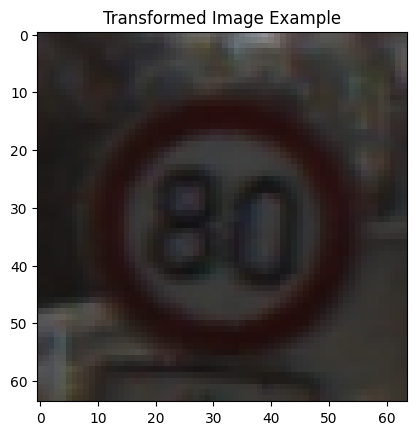

In [64]:
def show_image(image):
    image = image.numpy().transpose((1, 2, 0))
    image = (image * 0.5) + 0.5  # Unnormalize
    plt.imshow(image)
    plt.title('Transformed Image Example')
    plt.show()
    
example_image, _ = train_dataset[0]
show_image(example_image)

### Evaluation

In [65]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(data_loader):
        images, labels = images.to(device), labels.to(device)
        if model_type == 'vit':
            outputs = model(images).logits
        else:
            outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        #print(predicted, labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {correct / total:.2%}')

100%|███████████████████████████████████████████████████████████████████████████████| 1226/1226 [00:04<00:00, 273.81it/s]

Accuracy: 99.29%


### Attack
- patch size
- patch position
- patch transparency (alpha)

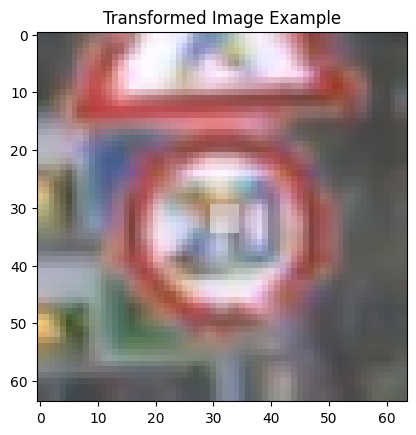

In [66]:
def show_image(image):
    image = image.numpy().transpose((1, 2, 0))
    image = (image * 0.5) + 0.5  # Unnormalize
    plt.imshow(image)
    plt.title('Transformed Image Example')
    plt.show()
    
def add_white_rectangle(image, rect_size=(5, 5), position=(30, 30), alpha=0.5):
    image = image.clone()
    for c in range(image.size(0)):  # Iterate over color channels
        image[c, position[0]:position[0]+rect_size[0], position[1]:position[1]+rect_size[1]] = \
            alpha * 1.0 + (1 - alpha) * image[c, position[0]:position[0]+rect_size[0], position[1]:position[1]+rect_size[1]]
    return image

example_image, _ = dataset[0]
patch_image = add_white_rectangle(example_image)
show_image(patch_image)

In [67]:
# Evaluation after Attack
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(data_loader):
        images, labels = images.to(device), labels.to(device)
        images = torch.stack([add_white_rectangle(img) for img in images])
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy: {correct / total:.2%}')

100%|███████████████████████████████████████████████████████████████████████████████| 1226/1226 [00:09<00:00, 133.45it/s]

Accuracy: 84.36%


In [68]:
# Attack: Different Transparecy
model.eval()

alphas = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
accuracies = []
for alpha in alphas:
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images, labels = images.to(device), labels.to(device)
            images = torch.stack([add_white_rectangle(img, alpha=alpha) for img in images])
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    accuracy = correct / total
    accuracies.append(accuracy)
    print(f'Alpha: {alpha}, Accuracy: {accuracy:.2%}')

100%|███████████████████████████████████████████████████████████████████████████████| 1226/1226 [00:09<00:00, 135.42it/s]


Alpha: 0.0, Accuracy: 99.29%


100%|███████████████████████████████████████████████████████████████████████████████| 1226/1226 [00:09<00:00, 132.71it/s]


Alpha: 0.2, Accuracy: 94.40%


100%|███████████████████████████████████████████████████████████████████████████████| 1226/1226 [00:09<00:00, 132.72it/s]


Alpha: 0.4, Accuracy: 87.41%


100%|███████████████████████████████████████████████████████████████████████████████| 1226/1226 [00:09<00:00, 128.26it/s]


Alpha: 0.6, Accuracy: 81.49%


100%|███████████████████████████████████████████████████████████████████████████████| 1226/1226 [00:09<00:00, 132.15it/s]


Alpha: 0.8, Accuracy: 75.89%


100%|███████████████████████████████████████████████████████████████████████████████| 1226/1226 [00:09<00:00, 133.69it/s]

Alpha: 1.0, Accuracy: 71.62%


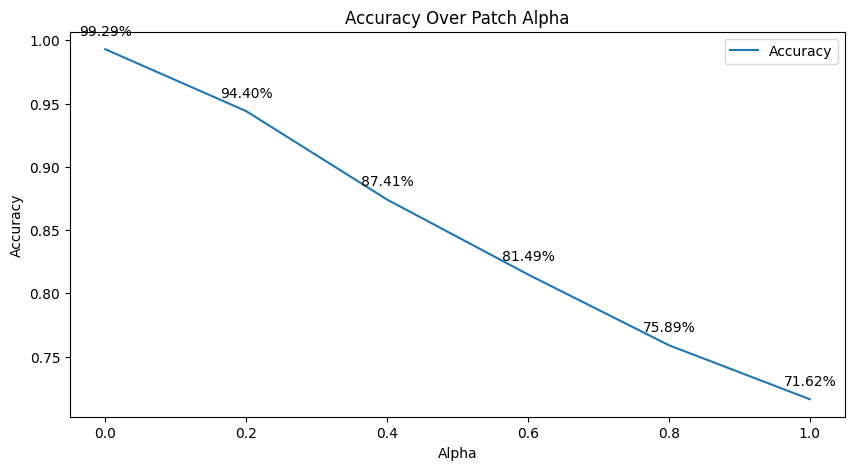

In [69]:
plt.figure(figsize=(10, 5))
plt.plot(alphas, accuracies, label='Accuracy')
for i, txt in enumerate(accuracies):
    plt.annotate(f'{txt:.2%}', (alphas[i], accuracies[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Patch Alpha')
plt.legend()
plt.show()

In [70]:
# Attack: Different Size
model.eval()

alphas = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
accuracies = []
for alpha in alphas:
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images, labels = images.to(device), labels.to(device)
            images = torch.stack([add_white_rectangle(img, alpha=alpha) for img in images])
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    accuracy = correct / total
    accuracies.append(accuracy)
    print(f'Alpha: {alpha}, Accuracy: {accuracy:.2%}')

100%|███████████████████████████████████████████████████████████████████████████████| 1226/1226 [00:09<00:00, 131.13it/s]


Alpha: 0.0, Accuracy: 99.29%


100%|███████████████████████████████████████████████████████████████████████████████| 1226/1226 [00:09<00:00, 127.06it/s]


Alpha: 0.2, Accuracy: 94.40%


100%|███████████████████████████████████████████████████████████████████████████████| 1226/1226 [00:09<00:00, 130.49it/s]


Alpha: 0.4, Accuracy: 87.41%


100%|███████████████████████████████████████████████████████████████████████████████| 1226/1226 [00:09<00:00, 131.74it/s]


Alpha: 0.6, Accuracy: 81.49%


100%|███████████████████████████████████████████████████████████████████████████████| 1226/1226 [00:09<00:00, 123.76it/s]


Alpha: 0.8, Accuracy: 75.89%


100%|███████████████████████████████████████████████████████████████████████████████| 1226/1226 [00:09<00:00, 132.13it/s]

Alpha: 1.0, Accuracy: 71.62%


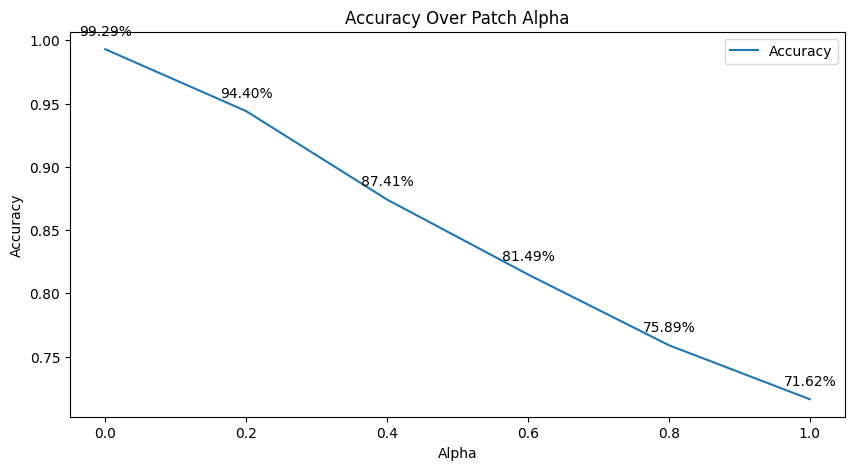

In [71]:
plt.figure(figsize=(10, 5))
plt.plot(alphas, accuracies, label='Accuracy')
for i, txt in enumerate(accuracies):
    plt.annotate(f'{txt:.2%}', (alphas[i], accuracies[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Patch Alpha')
plt.legend()
plt.show()